# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: Custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/04_pytorch_custom_datasets_video.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'2.3.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

Food101 full dataset - https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1. Visualizing and image

Let's write some code to:
1. Get all of the image paths.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using `pathlib.Path.parent.stem`.
4. Since we're working with images, let's open the image with Python's PIL - https://pillow.readthedocs.io/en/stable/.
5. We'll then show the image and print metadata.

data/pizza_steak_sushi/train/sushi/3579071.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/3579071.jpg
Image class: sushi
Image height: 512
Image width: 512


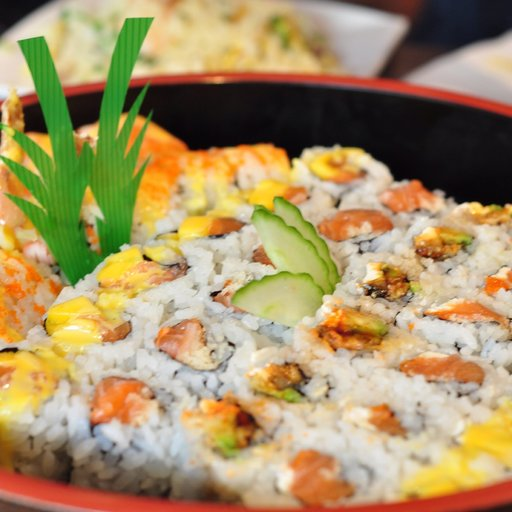

In [21]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

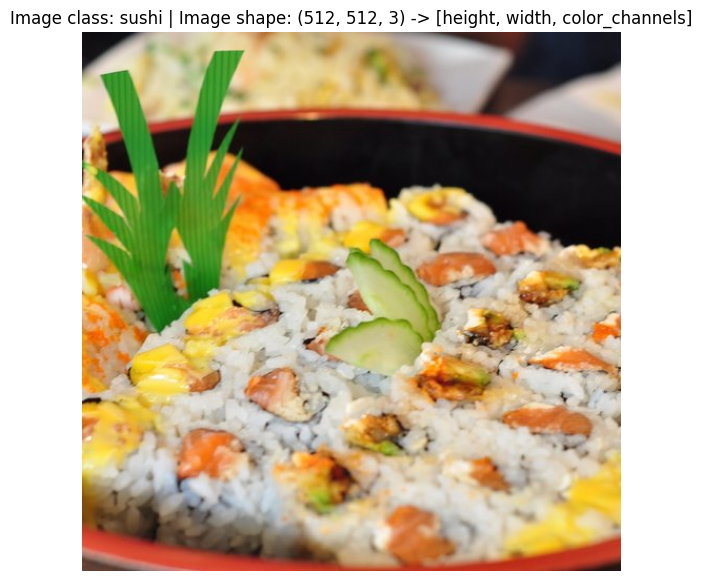

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

array([[[ 16,  14,  17],
        [ 16,  14,  17],
        [ 15,  13,  16],
        ...,
        [ 22,  22,  32],
        [ 22,  22,  32],
        [ 22,  22,  32]],

       [[ 16,  14,  17],
        [ 16,  14,  17],
        [ 16,  14,  17],
        ...,
        [ 22,  22,  32],
        [ 22,  22,  32],
        [ 22,  22,  32]],

       [[ 16,  14,  17],
        [ 16,  14,  17],
        [ 16,  14,  17],
        ...,
        [ 22,  22,  32],
        [ 22,  22,  32],
        [ 22,  22,  32]],

       ...,

       [[100,  70,  59],
        [100,  70,  59],
        [ 99,  70,  56],
        ...,
        [ 37,  22,  19],
        [ 37,  22,  19],
        [ 38,  23,  20]],

       [[ 99,  71,  59],
        [ 99,  71,  59],
        [ 98,  70,  58],
        ...,
        [ 40,  22,  20],
        [ 40,  22,  20],
        [ 40,  22,  20]],

       [[ 96,  70,  57],
        [ 96,  70,  57],
        [ 98,  70,  58],
        ...,
        [ 40,  22,  20],
        [ 41,  21,  20],
        [ 41,  21,  20]]], dtype=uint8)
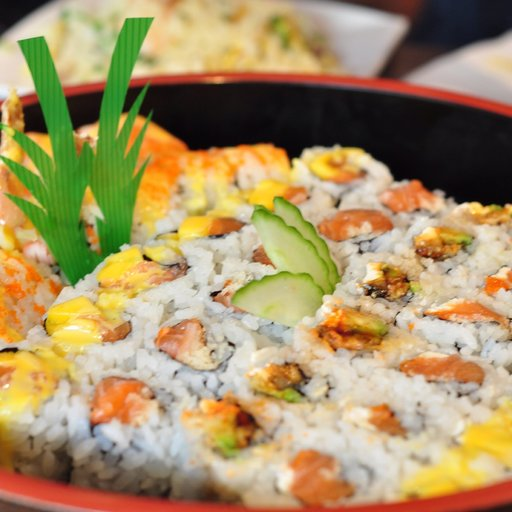

In [23]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [25]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [30]:
data_transform(img)

tensor([[[0.0627, 0.0588, 0.0588,  ..., 0.0863, 0.0902, 0.0863],
         [0.0706, 0.0706, 0.0784,  ..., 0.0902, 0.0863, 0.0863],
         [0.0784, 0.1098, 0.2863,  ..., 0.0824, 0.0824, 0.0863],
         ...,
         [0.8118, 0.8471, 0.8588,  ..., 0.7647, 0.7686, 0.7725],
         [0.5294, 0.5882, 0.6706,  ..., 0.7137, 0.6627, 0.5961],
         [0.3882, 0.3765, 0.4039,  ..., 0.3882, 0.2902, 0.2235]],

        [[0.0549, 0.0510, 0.0549,  ..., 0.0863, 0.0902, 0.0863],
         [0.0627, 0.0627, 0.0784,  ..., 0.0902, 0.0863, 0.0863],
         [0.0667, 0.0980, 0.2863,  ..., 0.0824, 0.0824, 0.0863],
         ...,
         [0.4471, 0.4039, 0.3608,  ..., 0.2235, 0.2235, 0.2314],
         [0.3725, 0.4118, 0.4549,  ..., 0.2196, 0.2118, 0.2039],
         [0.2627, 0.2627, 0.2863,  ..., 0.1333, 0.1137, 0.1059]],

        [[0.0667, 0.0627, 0.0706,  ..., 0.1176, 0.1216, 0.1255],
         [0.0745, 0.0745, 0.0863,  ..., 0.1216, 0.1176, 0.1255],
         [0.0824, 0.1098, 0.2863,  ..., 0.1137, 0.1137, 0.

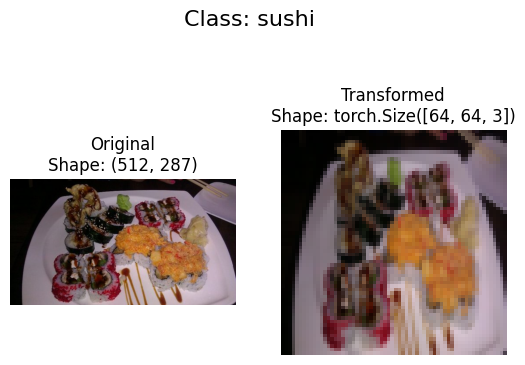

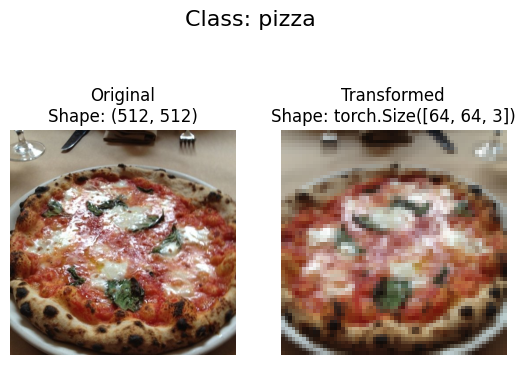

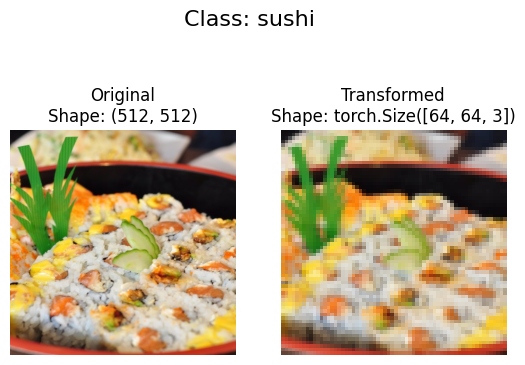

In [38]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms them then
  plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nShape: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [40]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None)  # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [41]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [42]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [43]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [44]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [46]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)